In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import os 
import sys 

# TODO: remove '..' if run from root folder
home = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
pths = [os.path.join(home, 'astrobot')]

for pth in pths: 
    if pth not in sys.path: sys.path.insert(0, pth)

from astrobot.util import *

import matplotlib.pyplot as plt 
import numpy as np 
from pprint import pprint as pp 
import pandas as pd 

# Tab after '.' to get all methods 
# Tab Shift after () to get documentation.
# To read excel data:
# pd.read_excel('afn_infil_data.xlsx')
# pd.read_clipboard()

# For experiments
# path to astrobot roo
ROOT_DIR

# path to this package from experiments folder
PACKAGE_FPATH_FOR_EXPERIMENTS

# path to epw from experiments folder
EPW_FPATH_FOR_EXPERIMENTS

'C:\\Users\\saeran2\\master\\git\\astrobot\\resources\\epw\\philadelphia\\philadelphia.epw'

In [4]:
# Finite difference approximation of heat conduction in 1d and 2d
import heat_fda as fda


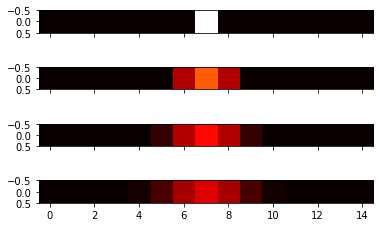

In [147]:
# 1d, with for loop (slow)
C, p, k = 420, 8, 13.44
dimt, dimx = 4, 1.5

ux = fda.oned_loop(dimt, dimx, C, p, k)
f, a = plt.subplots(4, 1, sharex=True)
t = 0
for i in np.linspace(0, dimt-1, 4).astype(int):
    a[t].imshow(ux[i, :].T, cmap='hot', aspect='equal', vmin=300, vmax=700)
    t += 1

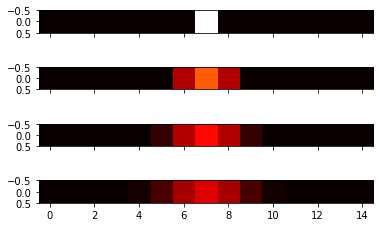

In [10]:
# 1d, with matrix
C, p, k = 420, 8, 13.44
dimt, dimx = 4, 1.5
uxy = fda.oned_mtx(dimt, dimx, C, p, k)

f, a = plt.subplots(4, 1, sharex=True)
t = 0
for i in np.linspace(0, dimt-1, 4).astype(int):
    a[t].imshow(ux[i, :].T, cmap='hot', aspect='equal', 
                vmin=300, vmax=700)
    t += 1

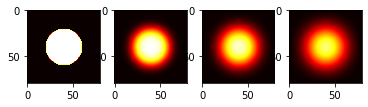

In [159]:
# 2d with loop
C, p, k = 420, 8, 13.44
dimt = 201
dimx, dimr = 8.1, 2 
uxy = fda.twod_loop(dimt, dimx, dimr, C, p, k)
f, a = plt.subplots(1, 4, sharex=True)
t = 0
for i in np.linspace(0, dimt-1, 4).astype(int):
    a[t].imshow(uxy[i, :, :], cmap='hot', aspect='equal', vmin=300, vmax=700)
    t += 1

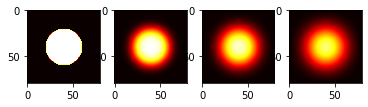

In [150]:
# 2d with loop
C, p, k = 420, 8, 13.44
dimt = 201
dimx, dimr = 8.1, 2 
uxy = fda.twod_mtx(dimt, dimx, dimr, C, p, k)
f, a = plt.subplots(1, 4, sharex=True)
t = 0
for i in np.linspace(0, dimt-1, 4).astype(int):
    a[t].imshow(uxy[i, :, :], cmap='hot', 
                aspect='equal', vmin=300, vmax=700)
    t += 1

# of nodes: 1.5/0.1 = 15


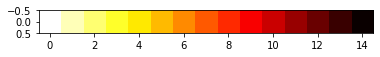

In [162]:
# 1d steady state heat conduction 
k = 2 # W/m2-k
dimx = 1.5
T0, TL = 20, 10
ux = fda.oned_steady_state(dimx, T0, TL, k)
# print('temp', np.round(ux.T, 6))
plt.imshow(ux.T, cmap='hot', aspect='equal')

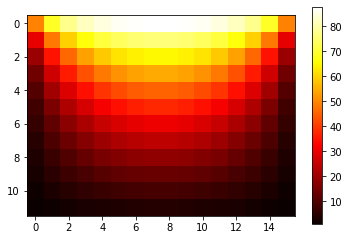

In [166]:
# 2d steady state heat conduction 
k = 2 # W/m2-k
dimx, dimy = 16, 12
top, bot, left, right = 100, 0, 0, 0  # C
bcs = (top, bot, left, right)
qx = k * 100 / 0.01  # W/m3
tgens = [] #[(6, 6, qx)]
uxy = fda.twod_steady_state(dimx, dimy, bcs, k, tgens)
plt.imshow(uxy, cmap='hot', aspect='equal')
plt.colorbar()

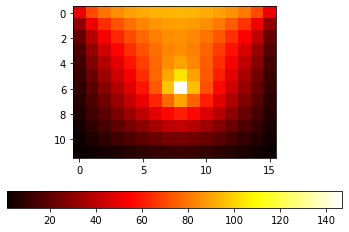

In [145]:
def _2d_adj_mtx(dimx, dimy):
    """Construct adjacency matrix for 2D nodes."""
    dimn, ri = dimx * dimy, ii * dimx
    A = np.diag(v=np.ones(dimn) * -4, k=0)
    A += np.diag(v=np.ones(dimn-1), k=-1)
    A += np.diag(v=np.ones(dimn-1), k=1)
    A += np.diag(v=np.ones(dimn-dimx), k=-dimx)
    A += np.diag(v=np.ones(dimn-dimx), k=dimx)
    ii = np.arange(1, dimy).astype(int)
    A[ri - 1, ri] = 0 # remove right-most value for top row
    A[ri, ri - 1] = 0 # remove left-most value for bottom row
    return A

def _2d_steady_state(dimx, dimy, bcs, k, qgens=None):
    """2D steady state heat conduction from pg. 326 of Cengel: 
        k(Tx3 + Ty3 - 4*T2 + Tx1 + Ty1) / dx2 = 0
    """
    DX2, Tup, Tdown, Tleft, Tright = 0.01, bcs
    qgens = [] if not qgens else qgens
    A = _2d_adj_mtx(dimx, dimy)

    # Add constant temps from boundary
    y = np.zeros((dimx * dimy, 1))
    row_bc_idxs = np.arange(0, dimx * dimy, dimx).astype(int)
    y[row_bc_idxs - 1] += -Tright
    y[row_bc_idxs] += -Tleft
    row_bc_idxs = np.arange(dimx).astype(int)  # first dimx nodes
    y[row_bc_idxs] += -Tup
    row_bc_idxs = (dimx * dimy) - 1 - row_bc_idxs  # last dimx nodes
    y[row_bc_idxs] += -Tdown

    # Add heat source and convert to C
    for ci, ri, qgen in qgens:
        A_idx = (ri * dimx) + ci
        y[A_idx] += -(qgen * DX2 / k)  

    # Solve and reshape
    return (np.linalg.pinv(A) @ y).reshape(dimy, dimx)

k = 2 # W/m2-k
dimx, dimy = 16, 12
bcs = 100, 0, 0, 0  # C for top, bot, left, right
qx = k * 200 / 0.01  # W/m3
heat_source = [(8, 6, qx)]
uxy = _2d_steady_state(dimx, dimy, bcs, k, heat_source)
plt.imshow(uxy, cmap='hot', aspect='equal')
plt.colorbar(orientation='horizontal')

In [13]:
# Solution for Cengel problem 5-1, pg. 319
Q = 5e6  # W/m3
Tinf = 30 # C 
T0 = 0  # C 
k = 28  # W/mK 
dx = 0.02  # m 
dx2 = dx * dx 
h = 45  # W/m2K

# y: 2 x 1
y = np.array(
    [[Q * dx2 / k + T0], 
     [-(h * dx / k) * Tinf - (Q * dx2) / (2 * k)]
    ]
)

assert y.shape == (2, 1), y.shape
#assert np.allclose(y[0, 0], 71.43, 1e-2)
#assert np.allclose(y[1, 0], -36.68, 1e-2)

# A: 2 x 3
A = np.array(
    [[ 2, -1],
     [ 1, -(1 + (h * dx / k))]]
    )

#assert A.shape == (2, 3)
#assert np.allclose([[0, 2, -1], [0, 1, -1.032]], A, atol=1e-3)

# x: 4 x 1 = [T0, T1, T2, Tinf]

Ainv = np.linalg.pinv(A)  
#assert Ainv.shape == (3, 2)

# Solve 
#A * x = y 
#A-1 * y = x 
x = Ainv @ y
#assert x.shape == (3, 1)

np.round(x.T, 2) 

# T0 = 0 
# T1 = 103.73
# T2 = 136.


array([[103.73, 136.04]])